Using MPS
Loading data for transformer
Processed 200 matches
Processed 400 matches
Processed 600 matches
Processed 800 matches
Processed 1000 matches
Processed 1200 matches
Processed 1400 matches
Processed 1600 matches
Processed 1800 matches
Processed 2000 matches
Processed 2185 matches, created 33423 examples
Input features: 19


/var/folders/y7/49wy45ks7sv3890zpzvhdk1w0000gn/T/ipykernel_14756/2679679277.py:296: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  self.sequences = torch.FloatTensor(self.sequences)


Dataset split - Train: 23396, Val: 5013, Test: 5014
Model parameters: 4,784,897


/Users/devadathks004/Desktop/dls-system/venv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting transformer training
Epoch 1/80, Train: 3531.0101, Val: 670.9892, RMSE: 25.90
Epoch 2/80, Train: 482.8851, Val: 412.9180, RMSE: 20.32
Epoch 3/80, Train: 452.3704, Val: 408.9652, RMSE: 20.22
Epoch 5/80, Train: 444.8343, Val: 408.6518, RMSE: 20.22
Epoch 6/80, Train: 435.1496, Val: 405.7684, RMSE: 20.14
Epoch 7/80, Train: 433.7885, Val: 402.9698, RMSE: 20.07
Epoch 10/80, Train: 424.9882, Val: 396.6926, RMSE: 19.92
Epoch 11/80, Train: 417.1475, Val: 390.5470, RMSE: 19.76
Epoch 14/80, Train: 398.7338, Val: 382.5345, RMSE: 19.56
Epoch 15/80, Train: 396.6326, Val: 374.9978, RMSE: 19.36
Epoch 16/80, Train: 387.1795, Val: 374.0451, RMSE: 19.34
Epoch 18/80, Train: 372.1112, Val: 360.3741, RMSE: 18.98
Epoch 19/80, Train: 359.0430, Val: 349.9368, RMSE: 18.71
Epoch 20/80, Train: 347.6692, Val: 341.6901, RMSE: 18.48
Epoch 21/80, Train: 337.5671, Val: 345.1682, RMSE: 18.58
Epoch 22/80, Train: 325.2304, Val: 326.6801, RMSE: 18.07
Epoch 23/80, Train: 308.9144, Val: 310.4880, RMSE: 17.62
Epoch 

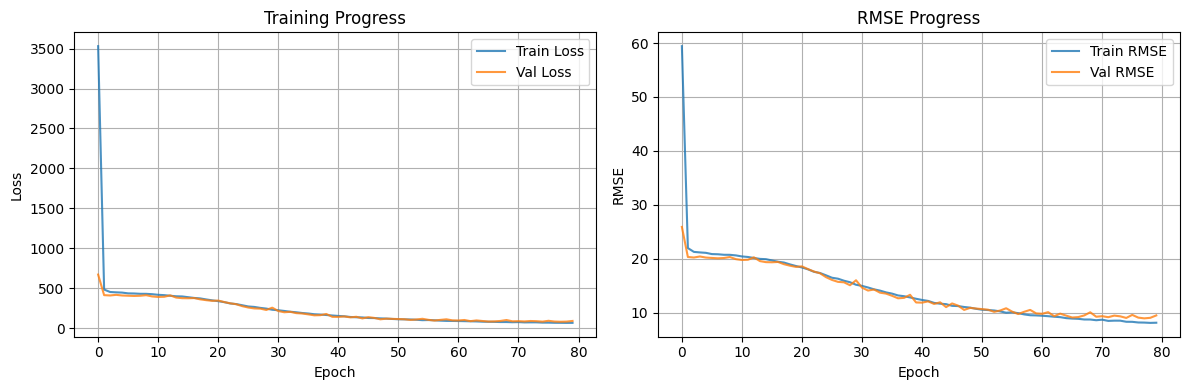

Transformer Results - RMSE: 8.48, MAE: 5.43, R2: 0.9587
Previous RNN: 7.86 RMSE
Transformer: 8.48 RMSE


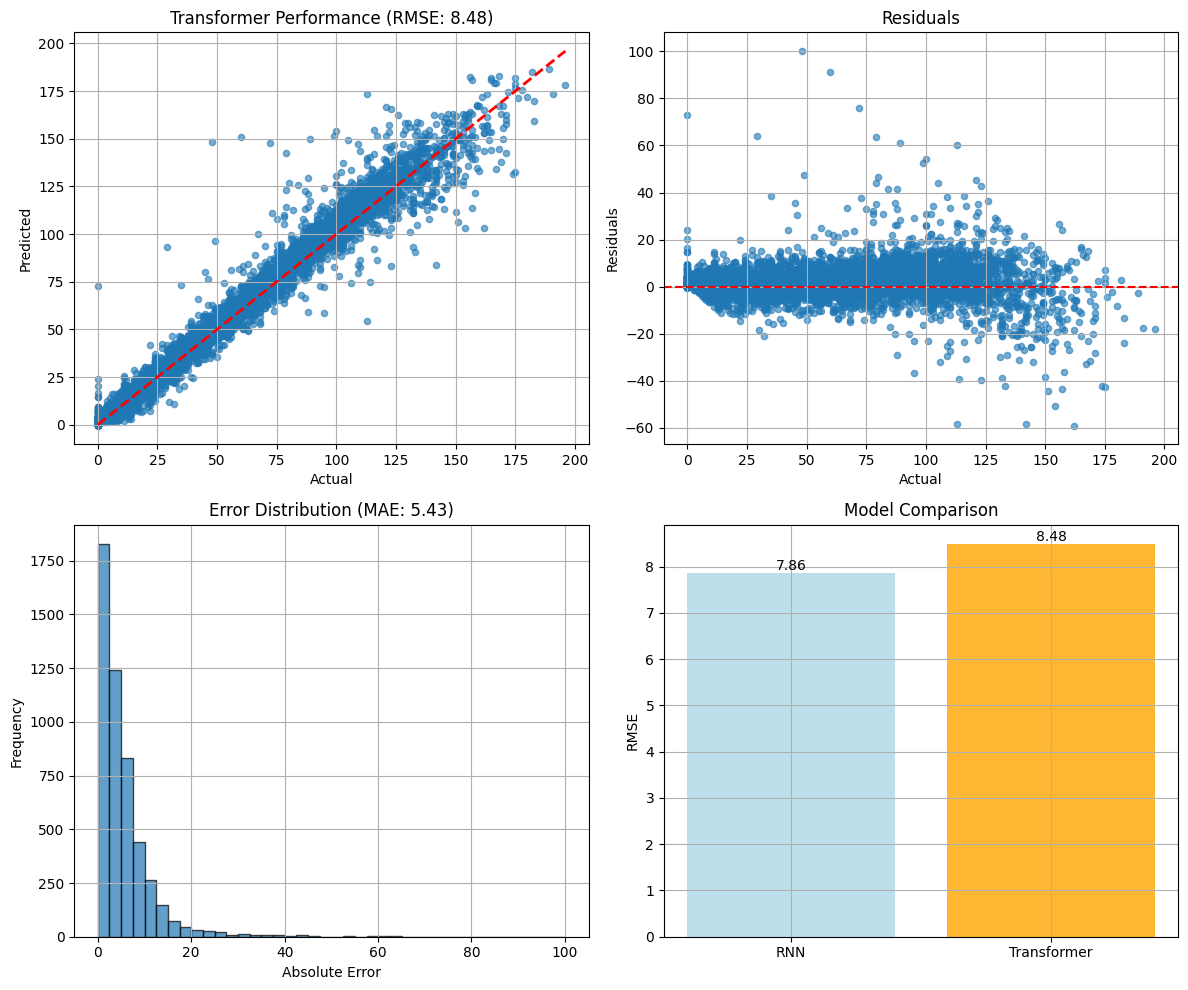

Transformer model training complete


In [1]:
# 06_transformer_model.ipynb

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
from glob import glob
import json
import random
import math

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

torch.set_num_threads(8)

class CricketPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=20, dropout=0.1):
        super(CricketPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class CricketMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(CricketMultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        output = torch.matmul(attention_weights, V)
        return output, attention_weights
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        attn_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        
        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model)
        
        output = self.W_o(attn_output)
        return output, attention_weights

class CricketFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(CricketFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.linear2(self.dropout(self.relu(self.linear1(x))))

class CricketTransformerLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(CricketTransformerLayer, self).__init__()
        self.self_attn = CricketMultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = CricketFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        attn_output, attention_weights = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x, attention_weights

class CricketTransformer(nn.Module):
    def __init__(self, input_size, d_model=256, num_heads=8, num_layers=6, d_ff=1024, 
                 max_seq_length=20, dropout=0.1):
        super(CricketTransformer, self).__init__()
        
        self.d_model = d_model
        self.input_size = input_size
        
        self.input_projection = nn.Linear(input_size, d_model)
        self.pos_encoding = CricketPositionalEncoding(d_model, max_seq_length, dropout)
        
        self.transformer_layers = nn.ModuleList([
            CricketTransformerLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, d_model // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 4, 1)
        )
        
        self.attention_weights = []
        
    def create_padding_mask(self, x):
        mask = (x.sum(dim=-1) != 0).unsqueeze(1).unsqueeze(1)
        return mask
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        mask = self.create_padding_mask(x)
        
        x = self.input_projection(x)
        
        x = x.transpose(0, 1)
        x = self.pos_encoding(x)
        x = x.transpose(0, 1)
        
        self.attention_weights = []
        for layer in self.transformer_layers:
            x, attn_weights = layer(x, mask)
            self.attention_weights.append(attn_weights.detach())
        
        if mask is not None:
            x = x.masked_fill(~mask.squeeze(1).squeeze(1).unsqueeze(-1), 0)
        
        x = x.transpose(1, 2)
        x = self.global_pool(x).squeeze(-1)
        
        output = self.output_projection(x)
        
        return output.squeeze(-1)
    
    def get_attention_weights(self):
        return self.attention_weights

def load_and_enhance_transformer_data():
    def calculate_advanced_momentum_single(df):
        df = df.copy()
        
        df['rr_momentum_3'] = 0.0
        df['rr_momentum_5'] = 0.0
        df['acceleration'] = 0.0
        df['pressure_index'] = 0.0
        df['wicket_cluster'] = 0.0
        df['economy_pressure'] = 0.0
        
        for i in range(len(df)):
            if i >= 3:
                recent_rr = df.iloc[i-3:i]['runs_in_over'].mean()
                overall_rr = df.iloc[:i]['runs_in_over'].sum() / i if i > 0 else 0
                df.iloc[i, df.columns.get_loc('rr_momentum_3')] = recent_rr - overall_rr
            
            if i >= 5:
                recent_rr = df.iloc[i-5:i]['runs_in_over'].mean()
                overall_rr = df.iloc[:i]['runs_in_over'].sum() / i
                df.iloc[i, df.columns.get_loc('rr_momentum_5')] = recent_rr - overall_rr
            
            if i >= 1:
                prev_rr = df.iloc[i-1]['run_rate']
                curr_rr = df.iloc[i]['run_rate']
                df.iloc[i, df.columns.get_loc('acceleration')] = curr_rr - prev_rr
            
            wickets_factor = df.iloc[i]['cumulative_wickets'] / 10
            overs_factor = (df.iloc[i]['over'] + 1) / 20
            pressure = wickets_factor * 0.6 + overs_factor * 0.4
            df.iloc[i, df.columns.get_loc('pressure_index')] = pressure
            
            if i >= 4:
                cluster = df.iloc[i-4:i+1]['wickets_in_over'].sum()
                df.iloc[i, df.columns.get_loc('wicket_cluster')] = cluster
            
            if i >= 2 and df.iloc[i]['bowler_economy'] > 0:
                avg_economy = df.iloc[i-2:i+1]['bowler_economy'].mean()
                economy_pressure = max(0, (8 - avg_economy) / 8)
                df.iloc[i, df.columns.get_loc('economy_pressure')] = economy_pressure
        
        return df
    
    sequence_files = glob('../data/processed/match_sequences/*.csv')
    
    enhanced_sequences = []
    targets = []
    metadata = []
    
    processed_count = 0
    
    for seq_file in sequence_files:
        try:
            df = pd.read_csv(seq_file)
            
            meta_file = seq_file.replace('.csv', '_meta.json')
            if not os.path.exists(meta_file):
                continue
                
            with open(meta_file, 'r') as f:
                meta = json.load(f)
            
            if len(df) < 5:
                continue
            
            enhanced_df = calculate_advanced_momentum_single(df)
            
            final_score = meta['final_score']
            
            for i in range(4, len(enhanced_df)):
                sequence = enhanced_df.iloc[:i+1]
                
                current_score = sequence.iloc[-1]['cumulative_runs']
                remaining_runs = final_score - current_score
                
                if 0 <= remaining_runs <= 200:
                    enhanced_sequences.append(sequence.values)
                    targets.append(remaining_runs)
                    metadata.append(meta)
            
            processed_count += 1
            if processed_count % 200 == 0:
                print(f"Processed {processed_count} matches")
                
        except Exception as e:
            continue
    
    print(f"Processed {processed_count} matches, created {len(enhanced_sequences)} examples")
    
    return enhanced_sequences, targets, metadata

class TransformerCricketDataset(Dataset):
    def __init__(self, sequences, targets, max_length=20, normalize=True):
        self.sequences = []
        self.targets = []
        
        for seq, target in zip(sequences, targets):
            if len(seq) > max_length:
                seq = seq[-max_length:]
            else:
                padding = np.zeros((max_length - len(seq), seq.shape[1]))
                seq = np.vstack([padding, seq])
            
            self.sequences.append(seq)
            self.targets.append(target)
        
        self.sequences = torch.FloatTensor(self.sequences)
        self.targets = torch.FloatTensor(self.targets)
        
        if normalize:
            self.normalize_features()
    
    def normalize_features(self):
        all_features = self.sequences.view(-1, self.sequences.shape[-1])
        self.feature_mean = all_features.mean(dim=0)
        self.feature_std = all_features.std(dim=0) + 1e-8
        
        self.sequences = (self.sequences - self.feature_mean) / self.feature_std
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

def train_transformer_model(model, train_loader, val_loader, num_epochs=100):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=8, factor=0.5, verbose=True)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 15
    
    print("Starting transformer training")
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_val_loss': best_val_loss,
                'feature_mean': dataset.feature_mean,
                'feature_std': dataset.feature_std,
                'input_size': model.input_size,
                'd_model': model.d_model
            }, '../data/processed/transformer_cricket_model.pth')
        else:
            patience_counter += 1
        
        if epoch % 10 == 0 or patience_counter == 0:
            rmse = np.sqrt(avg_val_loss)
            print(f'Epoch {epoch+1}/{num_epochs}, Train: {avg_train_loss:.4f}, Val: {avg_val_loss:.4f}, RMSE: {rmse:.2f}')
        
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    return train_losses, val_losses

def evaluate_transformer_model(model, test_loader, dataset):
    checkpoint = torch.load('../data/processed/transformer_cricket_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    
    ss_res = np.sum((actuals - predictions) ** 2)
    ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    print(f"Transformer Results - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")
    
    return predictions, actuals, rmse, mae, r2

# Load data
print("Loading data for transformer")
sequences, targets, metadata = load_and_enhance_transformer_data()

if len(sequences) > 0:
    input_size = sequences[0].shape[1]
    print(f"Input features: {input_size}")
    
    dataset = TransformerCricketDataset(sequences, targets)
    
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )
    
    batch_size = 64 if device.type == "mps" else 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0)
    
    print(f"Dataset split - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
    
    model = CricketTransformer(
        input_size=input_size,
        d_model=256,
        num_heads=8,
        num_layers=6,
        d_ff=1024,
        max_seq_length=20,
        dropout=0.1
    )
    model = model.to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")
    
    train_losses, val_losses = train_transformer_model(model, train_loader, val_loader, num_epochs=80)
    
    # Training visualization
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', alpha=0.8)
    plt.plot(val_losses, label='Val Loss', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    train_rmse = [np.sqrt(loss) for loss in train_losses]
    val_rmse = [np.sqrt(loss) for loss in val_losses]
    plt.plot(train_rmse, label='Train RMSE', alpha=0.8)
    plt.plot(val_rmse, label='Val RMSE', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('RMSE Progress')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    predictions, actuals, rmse, mae, r2 = evaluate_transformer_model(model, test_loader, dataset)
    
    print(f"Previous RNN: 7.86 RMSE")
    print(f"Transformer: {rmse:.2f} RMSE")
    
    if rmse < 7.86:
        improvement = ((7.86 - rmse) / 7.86) * 100
        print(f"Improvement: {improvement:.1f}%")
    
    # Results visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    axes[0,0].scatter(actuals, predictions, alpha=0.6, s=20)
    axes[0,0].plot([0, max(actuals)], [0, max(actuals)], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual')
    axes[0,0].set_ylabel('Predicted')
    axes[0,0].set_title(f'Transformer Performance (RMSE: {rmse:.2f})')
    axes[0,0].grid(True)
    
    residuals = predictions - actuals
    axes[0,1].scatter(actuals, residuals, alpha=0.6, s=20)
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].set_xlabel('Actual')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Residuals')
    axes[0,1].grid(True)
    
    errors = np.abs(residuals)
    axes[1,0].hist(errors, bins=40, alpha=0.7, edgecolor='black')
    axes[1,0].set_xlabel('Absolute Error')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title(f'Error Distribution (MAE: {mae:.2f})')
    axes[1,0].grid(True)
    
    models = ['RNN', 'Transformer']
    rmse_values = [7.86, rmse]
    colors = ['lightblue', 'orange']
    
    bars = axes[1,1].bar(models, rmse_values, color=colors, alpha=0.8)
    axes[1,1].set_ylabel('RMSE')
    axes[1,1].set_title('Model Comparison')
    axes[1,1].grid(True)
    
    for bar, value in zip(bars, rmse_values):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                      f'{value:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print("Transformer model training complete")
    
else:
    print("No training data loaded")